## Imports

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn import svm, linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib



import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

sys.path.insert(0, '../../../Utils/')

import models
from train import *
from metrics import * 
from SVC_Utils import *

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## NN Hyperparameters

In [2]:
n_epochs = 25
batch_size = 128
lr = 0.001
k = 3

target_net_type = models.mlleaks_cnn
shadow_net_type = models.mlleaks_cnn

## Load CIFAR10

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


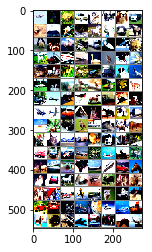

In [3]:
# define series of transforms to pre process images 
train_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    

    #torchvision.transforms.RandomRotation(10),
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10('../../../Datasets/', train=True, transform=train_transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#for svms
sv_cifar10_trainset = torchvision.datasets.CIFAR10('../../../Datasets/', train=True, transform=torchvision.transforms.ToTensor(), download=True)
sv_cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10('../../../Datasets/', train=False, transform=test_transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=32, shuffle=False, num_workers=2)

sv_cifar10_testset = torchvision.datasets.CIFAR10('../../../Datasets/', train=False, transform=torchvision.transforms.ToTensor(), download=True)
sv_cifar10_testloader = torch.utils.data.DataLoader(sv_cifar10_testset, batch_size=cifar10_testset.__len__(), shuffle=True, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(cifar10_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

In [4]:
# Creates two non-overlapping subsets of CIFAR10 to train the shadow and target models. We assume the attacker 
# has access to data that is similar to but not the same as the data used to train the target.

total_size = len(cifar10_trainset)
split1 = total_size // 4
split2 = split1*2
split3 = split1*3

indices = list(range(total_size))

shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]


shadow_train_sampler = SubsetRandomSampler(shadow_train_idx)
shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)
target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

shadow_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_train_sampler, num_workers=1)
shadow_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_out_sampler, num_workers=1)

#To fit shadow SVM
sv_shadow_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=shadow_train_sampler.__len__(), sampler=shadow_train_sampler, num_workers=1)

#attack_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, sampler=shadow_train_sampler, num_workers=1)

#attack_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, sampler=shadow_out_sampler, num_workers=1)
target_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
target_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)

#for svms
sv_target_train_loader = torch.utils.data.DataLoader(sv_cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
sv_target_out_loader = torch.utils.data.DataLoader(sv_cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)


# Initialize/Train Targets
The model being attacked; if network, architecture can differ from that of shadow network.

In [5]:
#Initialize NN
target_net = target_net_type().to(device)
target_net.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)

In [6]:
#Train NN
train(target_net, target_train_loader, cifar10_testloader, target_optim, target_loss, n_epochs, classes=classes)

[0/25]
Accuracy of airplane : 36.80 %
Accuracy of automobile : 28.10 %
Accuracy of bird : 34.20 %
Accuracy of cat : 12.80 %
Accuracy of deer : 19.10 %
Accuracy of dog : 36.50 %
Accuracy of frog : 44.60 %
Accuracy of horse : 54.40 %
Accuracy of ship : 8.10 %
Accuracy of truck : 67.50 %

Total accuracy = 34.21 %


[1/25]
Accuracy of airplane : 38.70 %
Accuracy of automobile : 34.00 %
Accuracy of bird : 73.10 %
Accuracy of cat : 16.90 %
Accuracy of deer : 7.40 %
Accuracy of dog : 17.40 %
Accuracy of frog : 26.30 %
Accuracy of horse : 32.40 %
Accuracy of ship : 23.60 %
Accuracy of truck : 72.90 %

Total accuracy = 34.27 %


[2/25]
Accuracy of airplane : 62.20 %
Accuracy of automobile : 85.60 %
Accuracy of bird : 57.30 %
Accuracy of cat : 36.70 %
Accuracy of deer : 19.20 %
Accuracy of dog : 40.60 %
Accuracy of frog : 18.80 %
Accuracy of horse : 19.90 %
Accuracy of ship : 51.00 %
Accuracy of truck : 4.60 %

Total accuracy = 39.59 %


[3/25]
Accuracy of airplane : 41.90 %
Accuracy of automobi

In [ ]:
#Initialize NN

#The stored baseline SVM was fit using all of CIFAR10 training data. To attack for membership inference, use 
#images not in CIFAR10 training data, or fit new classifiers/run source code with subset of CIFAR10.

'''
dir='../../../Classification_baselines/CIFAR10'
target_gen=load_svm(dir, gen=True)
target_maxacc=load_svm(dir, gen=False)
'''

#Training example targets on loaded CIFAR10 target subset:

gen_svm=make_pipeline(PCA(n_components=180), MinMaxScaler(feature_range=(-1,1)), svm.SVC(C=10, gamma=.1, probability=True))
maxacc_svm=make_pipeline(PCA(n_components=180), MinMaxScaler(feature_range=(-1,1)), svm.SVC(C=1, gamma=.01, probability=True))

sv_target_fit_loader = torch.utils.data.DataLoader(sv_cifar10_trainset, batch_size=target_train_sampler.__len__(), sampler=target_train_sampler, num_workers=1)
tin, tout=load(sv_target_fit_loader)

#Train SVM
gen_svm.fit(tin, tout)
maxacc_svm.fit(tin, tout)

In [ ]:
#evaluate SVM targets

inp, outp=load(sv_cifar10_testloader)

print('SVM A (C=', gen_svm.get_params(deep=True)['svc__C'], ', gamma= ',
      gen_svm.get_params(deep=True)['svc__gamma'], '): ')
class_acc(gen_svm.predict_proba(inp), outp, classes)

print('SVM B (C=', maxacc_svm.get_params(deep=True)['svc__C'], ', gamma= ',
      maxacc_svm.get_params(deep=True)['svc__gamma'], '): ')
class_acc(maxacc_svm.predict_proba(inp), outp, classes)

# Initialize/Train Shadow Model
Shadow model mimics the target network, emulating the target model's differences in prediction probabilities for samples in and out of its dataset. For this attack, only one shadow model is used. 

In [8]:
#Initialize models

#NN
shadow_net = shadow_net_type().to(device)
shadow_net.apply(models.weights_init)

shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=lr)

#SVM
shadowinputs, shadowtargets=load(sv_shadow_train_loader)
shadow_svm=make_pipeline(PCA(n_components=180), MinMaxScaler(feature_range=(-1,1)), 
                         svm.SVC(C=1, gamma=.1, probability=True))

In [9]:
#Train NN
train(shadow_net, shadow_train_loader, cifar10_testloader, shadow_optim, shadow_loss, n_epochs, classes=classes)

[0/25]
Accuracy of airplane : 56.00 %
Accuracy of automobile : 44.30 %
Accuracy of bird : 11.30 %
Accuracy of cat : 2.30 %
Accuracy of deer : 16.80 %
Accuracy of dog : 67.90 %
Accuracy of frog : 11.40 %
Accuracy of horse : 42.60 %
Accuracy of ship : 45.30 %
Accuracy of truck : 58.70 %

Total accuracy = 35.66 %


[1/25]
Accuracy of airplane : 72.00 %
Accuracy of automobile : 42.40 %
Accuracy of bird : 56.70 %
Accuracy of cat : 1.90 %
Accuracy of deer : 0.40 %
Accuracy of dog : 40.20 %
Accuracy of frog : 75.00 %
Accuracy of horse : 18.10 %
Accuracy of ship : 24.60 %
Accuracy of truck : 9.30 %

Total accuracy = 34.06 %


[2/25]
Accuracy of airplane : 67.80 %
Accuracy of automobile : 44.50 %
Accuracy of bird : 36.30 %
Accuracy of cat : 11.10 %
Accuracy of deer : 6.90 %
Accuracy of dog : 69.90 %
Accuracy of frog : 55.30 %
Accuracy of horse : 61.10 %
Accuracy of ship : 70.20 %
Accuracy of truck : 31.60 %

Total accuracy = 45.47 %


[3/25]
Accuracy of airplane : 59.60 %
Accuracy of automobile

In [10]:
#Train SVM
shadow_svm.fit(shadowinputs, shadowtargets)

['shadow']

# Initialize Attack Model
A binary classifier to determine membership. 

In [11]:
#Creates two attack nets for comparison.

attack_net_svm = models.mlleaks_mlp(n_in=k).to(device)
attack_net_svm.apply(models.weights_init)

attack_net_nn = models.mlleaks_mlp(n_in=k).to(device)
attack_net_nn.apply(models.weights_init)

#attack_loss = nn.BCEWithLogitsLoss()
attack_loss = nn.BCELoss()
attack_optim_svm= optim.Adam(attack_net_svm.parameters(), lr=lr)
attack_optim_nn= optim.Adam(attack_net_nn.parameters(), lr=lr)

[0/2][0/98] loss = 0.69, accuracy = 56.64
[0/2][1/98] loss = 0.69, accuracy = 58.79
[0/2][2/98] loss = 0.69, accuracy = 59.38
[0/2][3/98] loss = 0.69, accuracy = 58.98
[0/2][4/98] loss = 0.69, accuracy = 58.52
[0/2][5/98] loss = 0.69, accuracy = 58.66
[0/2][6/98] loss = 0.69, accuracy = 58.82
[0/2][7/98] loss = 0.69, accuracy = 58.54
[0/2][8/98] loss = 0.69, accuracy = 58.51
[0/2][9/98] loss = 0.69, accuracy = 58.98
[0/2][10/98] loss = 0.69, accuracy = 59.38
[0/2][11/98] loss = 0.69, accuracy = 59.51
[0/2][12/98] loss = 0.69, accuracy = 59.77
[0/2][13/98] loss = 0.69, accuracy = 59.93
[0/2][14/98] loss = 0.69, accuracy = 59.97
[0/2][15/98] loss = 0.69, accuracy = 60.33
[0/2][16/98] loss = 0.69, accuracy = 60.50
[0/2][17/98] loss = 0.69, accuracy = 60.59
[0/2][18/98] loss = 0.69, accuracy = 60.24
[0/2][19/98] loss = 0.69, accuracy = 60.29
[0/2][20/98] loss = 0.69, accuracy = 60.40
[0/2][21/98] loss = 0.69, accuracy = 60.23
[0/2][22/98] loss = 0.69, accuracy = 60.36
[0/2][23/98] loss = 0

[1/2][93/98] loss = 0.67, accuracy = 60.56
[1/2][94/98] loss = 0.68, accuracy = 60.55
[1/2][95/98] loss = 0.68, accuracy = 60.51
[1/2][96/98] loss = 0.68, accuracy = 60.51
[1/2][97/98] loss = 0.67, accuracy = 60.52


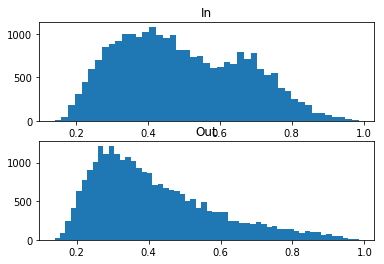

In [20]:
#Trains SVM attack model
train_attacker(attack_net_svm, shadow_svm, shadow_train_loader, shadow_out_loader, attack_optim_svm, attack_loss, n_epochs=2, k=k)

In [21]:
#Trains NN attack model
train_attacker(attack_net_nn, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim_nn, attack_loss, n_epochs=50, k=k)

[0/50][0/98] loss = 0.72, accuracy = 50.00
[0/50][1/98] loss = 0.72, accuracy = 50.00
[0/50][2/98] loss = 0.71, accuracy = 50.00
[0/50][3/98] loss = 0.71, accuracy = 50.00
[0/50][4/98] loss = 0.71, accuracy = 50.00
[0/50][5/98] loss = 0.71, accuracy = 50.00
[0/50][6/98] loss = 0.71, accuracy = 50.00
[0/50][7/98] loss = 0.71, accuracy = 50.00
[0/50][8/98] loss = 0.71, accuracy = 50.00
[0/50][9/98] loss = 0.70, accuracy = 50.00
[0/50][10/98] loss = 0.70, accuracy = 50.00
[0/50][11/98] loss = 0.70, accuracy = 50.00
[0/50][12/98] loss = 0.70, accuracy = 50.00
[0/50][13/98] loss = 0.70, accuracy = 50.00
[0/50][14/98] loss = 0.70, accuracy = 50.00
[0/50][15/98] loss = 0.70, accuracy = 50.00
[0/50][16/98] loss = 0.70, accuracy = 50.00
[0/50][17/98] loss = 0.70, accuracy = 50.00
[0/50][18/98] loss = 0.70, accuracy = 50.00
[0/50][19/98] loss = 0.70, accuracy = 50.00
[0/50][20/98] loss = 0.70, accuracy = 50.00
[0/50][21/98] loss = 0.70, accuracy = 50.00
[0/50][22/98] loss = 0.70, accuracy = 50.0

[1/50][95/98] loss = 0.69, accuracy = 62.13
[1/50][96/98] loss = 0.69, accuracy = 62.08
[1/50][97/98] loss = 0.69, accuracy = 62.07
[2/50][0/98] loss = 0.69, accuracy = 63.67
[2/50][1/98] loss = 0.68, accuracy = 64.26
[2/50][2/98] loss = 0.69, accuracy = 64.19
[2/50][3/98] loss = 0.69, accuracy = 64.26
[2/50][4/98] loss = 0.69, accuracy = 64.53
[2/50][5/98] loss = 0.69, accuracy = 64.26
[2/50][6/98] loss = 0.69, accuracy = 63.84
[2/50][7/98] loss = 0.69, accuracy = 63.77
[2/50][8/98] loss = 0.69, accuracy = 63.37
[2/50][9/98] loss = 0.69, accuracy = 62.89
[2/50][10/98] loss = 0.69, accuracy = 62.82
[2/50][11/98] loss = 0.69, accuracy = 62.73
[2/50][12/98] loss = 0.69, accuracy = 62.50
[2/50][13/98] loss = 0.69, accuracy = 62.61
[2/50][14/98] loss = 0.69, accuracy = 62.47
[2/50][15/98] loss = 0.68, accuracy = 62.70
[2/50][16/98] loss = 0.69, accuracy = 62.57
[2/50][17/98] loss = 0.69, accuracy = 62.50
[2/50][18/98] loss = 0.69, accuracy = 62.48
[2/50][19/98] loss = 0.69, accuracy = 62.5

[3/50][90/98] loss = 0.68, accuracy = 62.70
[3/50][91/98] loss = 0.68, accuracy = 62.69
[3/50][92/98] loss = 0.68, accuracy = 62.72
[3/50][93/98] loss = 0.68, accuracy = 62.70
[3/50][94/98] loss = 0.68, accuracy = 62.71
[3/50][95/98] loss = 0.68, accuracy = 62.71
[3/50][96/98] loss = 0.68, accuracy = 62.72
[3/50][97/98] loss = 0.68, accuracy = 62.71
[4/50][0/98] loss = 0.68, accuracy = 65.23
[4/50][1/98] loss = 0.68, accuracy = 64.65
[4/50][2/98] loss = 0.68, accuracy = 63.67
[4/50][3/98] loss = 0.69, accuracy = 62.40
[4/50][4/98] loss = 0.68, accuracy = 62.42
[4/50][5/98] loss = 0.68, accuracy = 62.57
[4/50][6/98] loss = 0.68, accuracy = 62.67
[4/50][7/98] loss = 0.68, accuracy = 62.21
[4/50][8/98] loss = 0.68, accuracy = 62.07
[4/50][9/98] loss = 0.68, accuracy = 62.07
[4/50][10/98] loss = 0.68, accuracy = 62.25
[4/50][11/98] loss = 0.69, accuracy = 62.04
[4/50][12/98] loss = 0.68, accuracy = 62.23
[4/50][13/98] loss = 0.68, accuracy = 62.28
[4/50][14/98] loss = 0.67, accuracy = 62.6

Process Process-275:
Process Process-274:
Traceback (most recent call last):
Traceback (most recent call last):


[4/50][68/98] loss = 0.68, accuracy = 62.52


  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in bat

# Evaluate Attack Nets
How well the trained attack models classify a sample as in or out of a target model's training dataset, and how performance is affected by target hyperparameters and which models attack which targets.

accuracy = 81.48, precision = 0.74, recall = 0.98


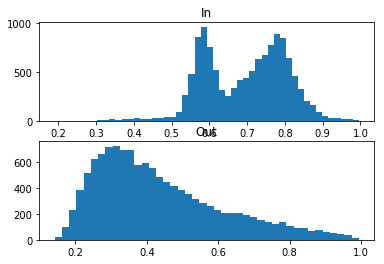

In [22]:
#attack net trained on svm shadow model on svm target, C=10, gamma=.1
eval_attack_net(attack_net_svm, gen_svm, sv_target_train_loader, sv_target_out_loader, k)

accuracy = 50.75, precision = 0.52, recall = 0.25


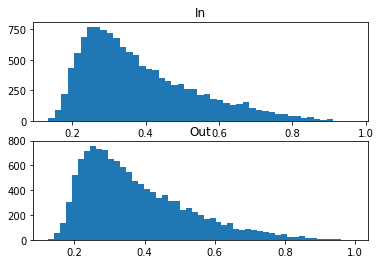

In [24]:
#attack net trained on svm shadow model on svm target, C=1, gamma=.01
eval_attack_net(attack_net_svm, maxacc_svm, sv_target_train_loader, sv_target_out_loader, k)

accuracy = 61.39, precision = 0.58, recall = 0.85


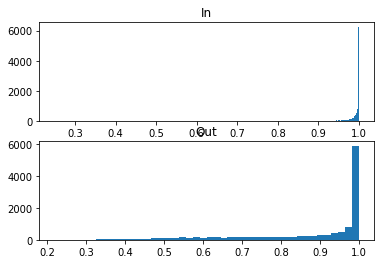

In [25]:
#attack net trained on nn shadow model on nn target
eval_attack_net(attack_net_nn, target_net, target_train_loader, target_out_loader, k)

accuracy = 53.92, precision = 0.82, recall = 0.10


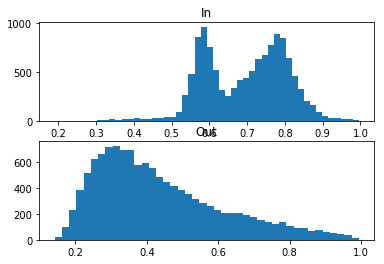

In [23]:
#attack net trained on nn shadow model on svm target, C=10, gamma=.1
eval_attack_net(attack_net_nn, gen_svm, sv_target_train_loader, sv_target_out_loader, k)